In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
import json
from src.metric_participants import ComputeMetrics
from pandasql import sqldf
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
from datetime import datetime

makeQuery = lambda q: sqldf(q, globals())

In [2]:
with open('./data/data_files/train_validation_split_5.json', 'r') as f: 
    cvSplit = json.load(f)

In [3]:
referenceDate = datetime.strptime('2020-07', '%Y-%m')
salesOffset = 100
salesTrain = pd.read_csv('./data/data_files/sales_train_splitted.csv', index_col=0)

regions = ['region_{}'.format(i) for i in range(201)]
months = list([datetime.strptime(m, '%Y-%m') for m in set(salesTrain.month.values.tolist())])
months.sort()
months = ['{}-{}'.format(d.year, '0'+str(d.month) if d.month < 10 else d.month) for d in months]
brands = ['brand_1', 'brand_2']

def sortDf(df: pd.DataFrame, isTrain: bool) -> pd.DataFrame: 
    tempRegions = regions[:151] if isTrain else regions[151:]
    df.region = pd.Categorical(df.region, tempRegions)
    df.month = pd.Categorical(df.month, months)
    df.sort_values(['region', 'month'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
salesTrain[(salesTrain['region'] == 'region_0') * (salesTrain['brand'] == 'brand_1')]

,month,region,brand,sales
0,2020-01,region_0,brand_1,0.00
905,2020-02,region_0,brand_1,0.00
1810,2020-03,region_0,brand_1,0.00
2715,2020-04,region_0,brand_1,0.00
3620,2020-05,region_0,brand_1,0.00
4525,2020-06,region_0,brand_1,0.00
5430,2020-07,region_0,brand_1,0.00
6335,2020-08,region_0,brand_1,612.44
7240,2020-09,region_0,brand_1,1653.59
8145,2020-10,region_0,brand_1,1898.56


In [5]:
# split by brand and transform time data to columns
def prepareRegionYTrue(salesTrain): 
    transformedData = {}
    for brand in brands: 
        brandData = {}
        for month in months: 
            query = """
            SELECT region, sales
            FROM salesTrain
            WHERE brand = '{brand}'
            AND month = '{month}'
            """.format(brand=brand, month=month)
            df = makeQuery(query)
            df.set_index('region', drop=True, inplace=True)
            brandData[month] = df['sales'].to_dict()
        df = pd.DataFrame.from_dict(brandData, orient='index').sort_index(ascending=True).T
        transformedData[brand] = pd.DataFrame(np.where((df == 0), sys.float_info.epsilon, df.values), index=df.index, columns=df.columns)
    return transformedData

transformedData = prepareRegionYTrue(salesTrain)

In [6]:
transformedData['brand_1'].head()

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
region_0,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,6.124400e+02,1.653590e+03,1898.56,2939.71,4440.19,3888.99,2664.11,5603.83,2572.25,4807.65,3674.64,4225.84,2927.80
region_1,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,7.655500e+02,1286.12,1653.59,1408.61,2021.05,1500.48,1837.32,1377.99,2021.05,2572.25,2204.78,3009.96
region_2,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,91.87,367.46,183.73,704.31,826.79,275.60,734.93,1561.72,1561.72,1469.86,2071.56
region_3,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.756000e+02,643.06,2021.05,275.60,2786.60,1224.88,2021.05,1010.53,2572.25,3858.37,2939.71,2374.68
region_4,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,9.187000e+01,1.500480e+03,459.33,1102.39,2939.71,1194.26,826.79,2572.25,2112.92,2112.92,1653.59,2847.85,2651.60


In [7]:
# def func(x, a, b): 
#     return a * np.log10(x) + b
def func(x, L ,x0, k, b):
    # code for fitting this curve was found here: https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

In [8]:
# fit a linear model on each region -> parameters are target values for prediction model
def fitSalesCurves(transformedData): 
    linearModels = {}
    failedModels = []
    initialGuesses = []
    for brand in brands: 
        # df = transformedData[brand].applymap(lambda x: np.log10(x) if x > 0 else 0)
        df = transformedData[brand]
        regionParameters = {}
        x = np.arange(6, df.shape[1]) # start at july
        for i, row in df.iterrows(): 
            # k, d = np.polyfit(x, row.values[6:], deg=1)
            # regionParameters[i] = {'k': k, 'd': d}
            #make initial guess
            y = row.values[6: ]
            initialGuess = [max(y), np.median(x),1,min(y)] 
            initialGuesses.append(initialGuess)
            bounds = (np.array(initialGuess)/2, np.array(initialGuess)*2)
            try: 
                fittedParams = curve_fit(func, x, y, initialGuess, method='dogbox', maxfev=10000, bounds=bounds)[0]
            except RuntimeError as e: 
                print(i, e)
                fittedParams = initialGuess
                failedModels.append(i)
            regionParameters[i] = {i: p for i, p in enumerate(fittedParams)}
        linearModels[brand] = pd.DataFrame.from_dict(regionParameters, orient='index')
    return linearModels

linearModels = fitSalesCurves(transformedData)

region_25 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_105 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_106 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_107 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_127 Optimal parameters not found: The maximum number of function evaluations is exceeded.


In [9]:
linearModels['brand_1']

,0,1,2,3
region_0,3874.530188,8.644169,1.091387,2.220446e-16
region_1,2286.782939,9.679291,0.500000,2.220446e-16
region_2,2206.956848,15.387595,0.500000,2.220446e-16
region_3,2776.771913,11.474562,0.500000,2.220446e-16
region_4,2311.421927,9.646685,0.500000,2.220446e-16
...,...,...,...,...
region_146,1929.190000,12.500000,1.000000,1.110223e-16
region_147,1614.303479,8.716248,2.000000,4.440892e-16
region_148,9008.297292,8.475338,1.481846,2.220446e-16
region_149,3154.070000,12.500000,1.000000,1.110223e-16


In [10]:
def predictSales(x, *params): 
    predictedSales = func(x, *params)
    return np.where(predictedSales < salesOffset, 0, predictedSales)  # consider these values 0


In [11]:
#modelType = LinearRegression
modelType = RandomForestRegressor
modelParams = {
    #'min_samples_split': 32, 
    #'min_samples_leaf': 16, 
    'n_estimators': 500, 
    #'max_depth': 5
}
# modelParams = {}
regionTrainFeatures = {brand: pd.read_csv('./data/data_files/region_features/training_{}.csv'.format(brand), index_col=0) for brand in brands}
monthsToPredict = np.arange(6, len(months))
monthColumns = months[6:]

In [12]:
def trainEstimationCrossValidation(): 
    models, scalers = {}, {}
    for fold, splits in cvSplit.items():
        trainingSplit, testSplit = splits['training'], splits['test']
        trainingSplit = ['region_{}'.format(i) for i in trainingSplit]
        testSplit = ['region_{}'.format(i) for i in testSplit]
        print('CV fold:', fold)

        brandModels, brandScalers = {}, {}
        for brand in brands: 
            print(brand)

            # define models and parameters, yTrue and make cross-validation
            modelyTrue = linearModels[brand]
            currentFeatures = regionTrainFeatures[brand]

            xTrain, xTest = currentFeatures.loc[trainingSplit].values, currentFeatures.loc[testSplit].values
            yTrain, yTest = modelyTrue.loc[trainingSplit].values, modelyTrue.loc[testSplit].values 

            # scale x data
            scaler = StandardScaler()
            xTrainScaled = scaler.fit_transform(xTrain)
            xTestScaled = scaler.transform(xTest)

            # train model
            model = modelType(**modelParams)
            model.fit(xTrainScaled, yTrain)

            brandModels[brand] = model
            brandScalers[brand] = scaler

        models[fold] = brandModels
        scalers[fold] = brandScalers
    return models, scalers

In [13]:
estimationCvModels, estimationCvScalers = trainEstimationCrossValidation()

CV fold: 0
brand_1
brand_2
CV fold: 1
brand_1
brand_2
CV fold: 2
brand_1
brand_2
CV fold: 3
brand_1
brand_2
CV fold: 4
brand_1
brand_2


In [14]:
def predictDataWithCvModels(features, models, scalers): 
    # evaluate cv. with each model, predict training data to get ci bounds. calculate score for each run and average
    brandPredictions = {}
    for brand in brands: 
        foldPredictions = {}
        for fold in models.keys(): 
            currentFeatures = features[brand]
            scaler = scalers[str(fold)][brand]
            xTrainScaled = scaler.transform(currentFeatures.values)
            model = models[str(fold)][brand]
            parameters = model.predict(xTrainScaled)
            
            predictedSales = []
            for params in parameters: 
                salesForecasts = predictSales(monthsToPredict, *params)
                predictedSales.append(salesForecasts)
            predictedSales = pd.DataFrame(predictedSales, index=currentFeatures.index)
            foldPredictions[int(fold)] = predictedSales
        brandPredictions[brand] = foldPredictions
    return brandPredictions


def getCiFromCv(predictions: Dict[int, pd.DataFrame], correctionFactor: float = 1) -> Tuple[pd.DataFrame, pd.DataFrame]: 
    """
    Calculate ci bounds, such that 80% of the yTrue points fall within the margin of yPred +- bounds. 
    CI is calculated for each data point
    """
    index = predictions[0].index.values
    stackedPredictions = np.stack([preds.values for preds in predictions.values()], axis=0)  # 3D -> fold, region, month
    # mean = stackedPredictions.mean(axis=0)  # average over folds
    lowerBound = np.percentile(stackedPredictions, 20, axis=0)
    upperBound = np.percentile(stackedPredictions, 80, axis=0)
    return (pd.DataFrame(lowerBound*correctionFactor, index=index), 
            pd.DataFrame(upperBound*correctionFactor, index=index))


def getCiBoundsFromCvData(cvPredictions): 
    cvCiBounds = {brand: getCiFromCv(cvPredictions[brand]) for brand in brands}
    for brand, bounds in cvCiBounds.items(): 
        lower, upper = bounds
        lower.rename(columns={c: monthColumns[c] for c in lower.columns.values}, inplace=True)
        upper.rename(columns={c: monthColumns[c] for c in upper.columns.values}, inplace=True)
    return cvCiBounds

In [15]:
def getSubmissionDataFromSales(predictions: Dict[str, pd.DataFrame], 
                               isTrain: bool = False
                              ) -> pd.DataFrame: 
    """
    Takse a dict for predictions and bounds. In both cases the keys are the brands. 
    The values for predictions are dataframes containing the predictions per region (index) and month (column). 
    The values for the bounds are tuples of two dataframes of lower and upper bounds with same index and 
    columns as the predictions df. 
    Transforms the data into a dataframe with columns, month, region, brand, sales, lower, upper, as required
    by the submission platform.
    """
    submissionData = []
    tempRegions = regions[:151] if isTrain else regions[151:]
    for brand in brands: 
        preds = predictions[brand]
        # lower, upper = bounds[brand]
        for region in tempRegions: 
            for month in months[6:]: 
                row = [month, region, brand, preds.at[region, month]]
                submissionData.append(row)
    submissionData = pd.DataFrame(submissionData, columns=['month', 'region', 'brand', 'sales'])
    # submissionData.sort_values(by=['month', 'region', 'brand'], ascending=True, inplace=True)
    # submissionData.reset_index(drop=True, inplace=True)
    sortDf(submissionData, isTrain)
    return submissionData

In [16]:
trainEstimatedSales = predictDataWithCvModels(regionTrainFeatures, estimationCvModels, estimationCvScalers)
ciBoundsEstimationTrain = getCiBoundsFromCvData(trainEstimatedSales)

In [17]:
def filterBrands(x): 
    return x in ['brand_1', 'brand_2']

def filterMonths(x): 
    d = datetime.strptime(x, '%Y-%m')
    return d >= referenceDate

def scoreEstimationCv(cvPredictions, isTrain):
    accScores, confScores = [], []
    submissions = {}
    # groundTruth = salesTrain[salesTrain['brand'].apply(filterBrands)][salesTrain['month'].apply(filterMonths)]
    for i in range(len(cvSplit.keys())): 
        foldData = {}
        for brand in brands: 
            df = cvPredictions[brand][i]
            df.rename(columns={c: monthColumns[c] for c in df.columns.values}, inplace=True)
            foldData[brand] = df

        submissionData = getSubmissionDataFromSales(foldData, isTrain)
        submissionData.rename(columns={'sales': 'sales_estimated'}, inplace=True)
        submissions[i] = submissionData
        
        
        #score = ComputeMetrics(submissionData, 
        #                       salesTrain, 
        #                       groundTruth)
        #accScores.append(score[0])
        #confScores.append(score[1])
        
    # print(np.mean(accScores), np.std(accScores), np.mean(confScores), np.std(confScores))
    return submissions

In [18]:
submissionsTrainEstimation = scoreEstimationCv(trainEstimatedSales, True)

In [19]:
submissionsTrainEstimation[0]

,month,region,brand,sales_estimated
0,2020-07,region_0,brand_1,117.509432
1,2020-07,region_0,brand_2,0.000000
2,2020-08,region_0,brand_1,310.612858
3,2020-08,region_0,brand_2,0.000000
4,2020-09,region_0,brand_1,758.464738
...,...,...,...,...
4223,2021-06,region_150,brand_2,3341.517605
4224,2021-07,region_150,brand_1,6094.571586
4225,2021-07,region_150,brand_2,3349.464754
4226,2021-08,region_150,brand_1,6095.845816


In [20]:
# load test data
# salesTest = pd.read_csv('./data/data_files/sales_test_splitted.csv', index_col=0)
testRegionFeatures = {brand: pd.read_csv('./data/data_files/region_features/test_{}.csv'.format(brand), index_col=0) for brand in brands}
testRegionFeatures['brand_1'].shape, testRegionFeatures['brand_2'].shape

((50, 26), (50, 19))

In [21]:
testEstimatedCvSales = predictDataWithCvModels(testRegionFeatures, estimationCvModels, estimationCvScalers)
submissionsTestEstimation = scoreEstimationCv(testEstimatedCvSales, False)
submissionsTestEstimation[0]

,month,region,brand,sales_estimated
0,2020-07,region_151,brand_1,0.000000
1,2020-07,region_151,brand_2,0.000000
2,2020-08,region_151,brand_1,0.000000
3,2020-08,region_151,brand_2,0.000000
4,2020-09,region_151,brand_1,0.000000
...,...,...,...,...
1395,2021-06,region_200,brand_2,1345.445614
1396,2021-07,region_200,brand_1,3598.472106
1397,2021-07,region_200,brand_2,1348.734607
1398,2021-08,region_200,brand_1,3601.520662


### Time-based prediction
The idea is to use the previous predictions as a baseline and now train an additional model on top, which predicts a correction on top of the base model. 

In [22]:
# prepare time data

def loadTimeData(isTrain): 
    timeData = {}
    for brand in brands: 
        df = pd.read_csv('./data/data_files/time_features/time_features_{}_{}.csv'.format(brand, 'train' if isTrain else 'test'), index_col=0)
        df = df[df['month'].apply(lambda x: datetime.strptime(x, '%Y-%m') >= referenceDate)]
        sortDf(df, isTrain)
        timeData[brand] = df
    return timeData
        
timeTrain = loadTimeData(True)
timeTrain['brand_1'].head(n=10)

,region,month,delta_interactions_1_f2f,delta_distinct_interactions_1_f2f,delta_interactions_1_other,delta_distinct_interactions_1_other,delta_interactions_1_phone,delta_distinct_interactions_1_phone,delta_interactions_1_video,delta_distinct_interactions_1_video,...,delta_distinct_interactions_2_video,delta_nr_contacts_1,delta_hcp_contacted_1,delta_mails_opened_1,delta_mails_clicked_1,delta_nr_contacts_2,delta_hcp_contacted_2,delta_mails_opened_2,delta_mails_clicked_2,market_potential
0,region_0,2020-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501181.82
1,region_0,2020-08,13.0,10.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478167.37
2,region_0,2020-09,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463424.44
3,region_0,2020-10,-15.0,-6.0,0.0,0.0,-3.0,-3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529006.82
4,region_0,2020-11,-4.0,-4.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,522498.60
5,region_0,2020-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,543796.76
6,region_0,2021-01,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,505188.62
7,region_0,2021-02,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,517642.40
8,region_0,2021-03,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,614682.66
9,region_0,2021-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,609680.12


In [23]:
def mergeEstimationTimeData(estimationCvSubmissions, timeData, isTrain): 
    mergedData = {}
    for fold, submission in estimationCvSubmissions.items(): 
        if 'lower' in submission.columns.values: 
            submission.drop('lower', axis=1, inplace=True)
        if 'upper' in submission.columns.values: 
            submission.drop('upper', axis=1, inplace=True)

        sortDf(submission, isTrain)
        
        foldMerged = {}
        for brand in brands: 
            merged = pd.concat([submission[submission['brand'] == brand].reset_index(drop=True), 
                                timeData[brand].drop(['month', 'region'], axis=1)], 
                               axis=1)
            merged.drop('brand', axis=1, inplace=True)
            foldMerged[brand] = merged
        mergedData[fold] = foldMerged
        
    return mergedData

In [24]:
trainMergedEstimationTimeData = mergeEstimationTimeData(submissionsTrainEstimation, timeTrain, True)
trainMergedEstimationTimeData[0]['brand_1'].head()

,month,region,sales_estimated,delta_interactions_1_f2f,delta_distinct_interactions_1_f2f,delta_interactions_1_other,delta_distinct_interactions_1_other,delta_interactions_1_phone,delta_distinct_interactions_1_phone,delta_interactions_1_video,...,delta_distinct_interactions_2_video,delta_nr_contacts_1,delta_hcp_contacted_1,delta_mails_opened_1,delta_mails_clicked_1,delta_nr_contacts_2,delta_hcp_contacted_2,delta_mails_opened_2,delta_mails_clicked_2,market_potential
0,2020-07,region_0,117.509432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501181.82
1,2020-08,region_0,310.612858,13.0,10.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478167.37
2,2020-09,region_0,758.464738,6.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463424.44
3,2020-10,region_0,1573.839122,-15.0,-6.0,0.0,0.0,-3.0,-3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529006.82
4,2020-11,region_0,2564.429804,-4.0,-4.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,522498.60


In [25]:
submissionsTestEstimation.keys()

dict_keys([0, 1, 2, 3, 4])

In [26]:
def loadTimeYTrueForBrands():
    loaded = {}
    for brand in brands: 
        df = pd.read_csv('./data/data_files/time_features/sales_delta_{}_train.csv'.format(brand), index_col=0)
        df = df[df['month'].apply(lambda x: datetime.strptime(x, '%Y-%m') >= referenceDate)]
        sortDf(df, True)
        loaded[brand] = df
    return loaded

In [27]:
timeYTrue = loadTimeYTrueForBrands()
timeYTrue['brand_1']

,region,month,sales,delta_sales,rel_delta_sales,prevSales
0,region_0,2020-07,0.00,0.00,0.000000,0.00
1,region_0,2020-08,612.44,612.44,100.000000,0.00
2,region_0,2020-09,1653.59,1041.15,1.700003,612.44
3,region_0,2020-10,1898.56,244.97,0.148144,1653.59
4,region_0,2020-11,2939.71,1041.15,0.548389,1898.56
...,...,...,...,...,...,...
2109,region_150,2021-04,6828.71,1286.13,0.232045,5542.58
2110,region_150,2021-05,6491.86,-336.85,-0.049328,6828.71
2111,region_150,2021-06,5726.31,-765.55,-0.117925,6491.86
2112,region_150,2021-07,8543.54,2817.23,0.491980,5726.31


In [28]:
def trainCvCorrectionModels(xTrain, yTrain, modelType, modelParams): 
    correctionCvModels = {}
    for fold, data in xTrain.items(): 
        
        foldModels = {}
        for brand in brands: 
            split = cvSplit[str(fold)]
            trainingSplit, testSplit = split['training'], split['test']
            trainingSplit = ['region_{}'.format(i) for i in trainingSplit]
            # testSplit = ['region_{}'.format(i) for i in testSplit]
            
            print('CV fold:', fold)
            
            currentY = yTrain[brand]
            currentX = xTrain[fold][brand]
            
            y = currentY[currentY['region'].apply(lambda x: x in trainingSplit)]['sales'].values
            x = currentX[currentX['region'].apply(lambda x: x in trainingSplit)]
            
            model = modelType(**modelParams)
            model.fit(x.values[:, 2:], y)
            
            foldModels[brand] = model
        
        correctionCvModels[fold] = foldModels#
    
    return correctionCvModels

In [29]:
modelType = RandomForestRegressor
modelParams = {
    'n_estimators': 100
}
correctionCvModels = trainCvCorrectionModels(trainMergedEstimationTimeData, timeYTrue, modelType, modelParams)

CV fold: 0
CV fold: 0
CV fold: 1
CV fold: 1
CV fold: 2
CV fold: 2
CV fold: 3
CV fold: 3
CV fold: 4
CV fold: 4


In [30]:
def predictCorrectionCvModels(x, models): 
    predictions = {}
    for fold, data in x.items(): 
        
        brandPredictions = {}
        for brand in brands: 
            model = models[fold][brand]
            
            currentFeatures = x[fold][brand]
            yPred = model.predict(currentFeatures.values[:, 2:])
            yPred = pd.DataFrame(yPred, columns=['sales'], index=currentFeatures.index)
            yPred = pd.concat([currentFeatures[['region', 'month']], yPred], axis=1)
            
            brandPredictions[brand] = yPred
            
        predictions[fold] = brandPredictions
    
    return predictions

In [31]:
correctedTrainPredictions = predictCorrectionCvModels(trainMergedEstimationTimeData, correctionCvModels)

In [32]:
correctedTrainPredictions[0]['brand_1']

,region,month,sales
0,region_0,2020-07,0.0000
1,region_0,2020-08,523.3306
2,region_0,2020-09,1516.4022
3,region_0,2020-10,2163.1347
4,region_0,2020-11,2690.3845
...,...,...,...
2109,region_150,2021-04,6987.2209
2110,region_150,2021-05,6894.6443
2111,region_150,2021-06,5388.6630
2112,region_150,2021-07,6608.3394


In [33]:
def getCiBoundsForCorrectionModels(correctionCvPredictions): 
    ciBounds = {}
    for brand in brands: 
        stacked = []
        for fold, data in correctionCvPredictions.items(): 
            df = data[brand]
            stacked.append(df['sales'].values.reshape(-1, 1))
        stacked = np.concatenate(stacked, axis=1)
        
        lower = pd.DataFrame(np.percentile(stacked, 20, axis=1), columns=['lower'])
        upper = pd.DataFrame(np.percentile(stacked, 80, axis=1), columns=['upper'])
        
        ciBounds[brand] = pd.concat([lower, upper], axis=1)
    return ciBounds

In [34]:
correctedTrainCiBounds = getCiBoundsForCorrectionModels(correctedTrainPredictions)
correctedTrainCiBounds['brand_1']

,lower,upper
0,0.00000,4.77704
1,501.40474,574.59112
2,1269.46616,1517.32104
3,1879.75952,2255.26806
4,2531.83630,2934.46134
...,...,...
2109,6666.50520,6920.25898
2110,6522.73830,6853.12854
2111,5994.20964,6291.07508
2112,7465.61396,8016.97760


In [35]:
def getSubmissionDataFromPredictionsAndCi(correctedCvPredictions, correctedCiBounds): 
    cvSubmissions = {}
    for fold, data in correctedCvPredictions.items(): 
        merged = []
        for brand in brands: 
            df = correctedCvPredictions[fold][brand]
            df['brand'] = brand
            bounds = correctedCiBounds[brand]
            df = pd.concat([df, bounds], axis=1)
            
            merged.append(df)
        
        submission = pd.concat(merged, axis=0)
        cvSubmissions[fold] = submission
            
    return cvSubmissions

In [36]:
correctedTrainCvSubmissions = getSubmissionDataFromPredictionsAndCi(correctedTrainPredictions, correctedTrainCiBounds)

In [37]:
correctedTrainCvSubmissions[0]

,region,month,sales,brand,lower,upper
0,region_0,2020-07,0.0000,brand_1,0.00000,4.77704
1,region_0,2020-08,523.3306,brand_1,501.40474,574.59112
2,region_0,2020-09,1516.4022,brand_1,1269.46616,1517.32104
3,region_0,2020-10,2163.1347,brand_1,1879.75952,2255.26806
4,region_0,2020-11,2690.3845,brand_1,2531.83630,2934.46134
...,...,...,...,...,...,...
2109,region_150,2021-04,4545.4419,brand_2,1172.80964,1981.06830
2110,region_150,2021-05,4049.9608,brand_2,1054.79712,1792.00104
2111,region_150,2021-06,3961.5420,brand_2,1641.13100,2360.81288
2112,region_150,2021-07,4498.4166,brand_2,1213.85880,1984.49700


In [38]:
def scoreCorrectCv(submissions): 
    accScores, confScores = [], []
    
    groundTruth = salesTrain[salesTrain['brand'].apply(filterBrands)].copy()
    groundTruth = groundTruth[groundTruth['month'].apply(filterMonths)]
    
    for fold, data in submissions.items(): 
        score = ComputeMetrics(data, salesTrain, groundTruth)
        accScores.append(score[0])
        confScores.append(score[1])
        
    print('Average accuracy score', np.mean(accScores))
    print('Average confidence score', np.mean(confScores))
    return accScores, confScores

In [39]:
accScores, confScores = scoreCorrectCv(correctedTrainCvSubmissions)
accScores, confScores

Average accuracy score 18.49515146468753
Average confidence score 64.49987456034074


([19.425714176254786,
  19.22362750081635,
  17.41552278716081,
  18.420520477689042,
  17.990372381516657],
 [64.49987456034074,
  64.49987456034074,
  64.49987456034074,
  64.49987456034074,
  64.49987456034074])

In [40]:
def getAverageSubmission(submissions): 
    sales = []
    for fold, data in submissions.items(): 
        sales.append(data['sales'].values.reshape(-1, 1))
    
    sales = np.concatenate(sales, axis=1)
    meanSales = np.mean(sales, axis=1)
    finalSubmission = submissions[0].copy()
    finalSubmission.drop('sales', axis=1, inplace=True)
    finalSubmission['sales'] = meanSales
    return finalSubmission

In [41]:
finalTrainSubmission = getAverageSubmission(correctedTrainCvSubmissions)
finalTrainSubmission.head()

,region,month,brand,lower,upper,sales
0,region_0,2020-07,brand_1,0.00000,4.77704,4.77704
1,region_0,2020-08,brand_1,501.40474,574.59112,533.49620
2,region_0,2020-09,brand_1,1269.46616,1517.32104,1327.89304
3,region_0,2020-10,brand_1,1879.75952,2255.26806,1927.67418
4,region_0,2020-11,brand_1,2531.83630,2934.46134,2657.33686


In [43]:
accScores, confScores = scoreCorrectCv({0: finalTrainSubmission})
accScores, confScores

Average accuracy score 16.88106334764241
Average confidence score 64.49987456034074


([16.88106334764241], [64.49987456034074])

In [51]:
def plotRandomRegions(submissionData: pd.DataFrame, 
                      brand: str, 
                      isTrain: bool = False, 
                      groundTruth: pd.DataFrame = None
                     ): 
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 8), sharex=True)
    for i in range(4): 
        for j in range(4): 
            if isTrain: 
                randomRegion = 'region_{}'.format(np.random.randint(151))
            else: 
                randomRegion = 'region_{}'.format(np.random.randint(151, 201, 1)[0])
            df = submissionData[submissionData['brand'] == brand]
            df = df[df['region'] == randomRegion]
            sales, lower, upper = df['sales'].values, df['lower'].values, df['upper'].values
            ax[i, j].plot(df['month'].values, sales, 'r--')
            ax[i, j].plot(df['month'].values, lower, 'b--')
            ax[i, j].plot(df['month'].values, upper, 'b--')
            
            if groundTruth is not None: 
                df = groundTruth[groundTruth['brand'] == brand]
                df = df[df['region'] == randomRegion]
                ax[i, j].plot(df['month'].values, df['sales'].values, 'g--')
            
    plt.setp(ax, 
             xticks=[df['month'].values[i] for i in range(df.shape[0]) if i%5 == 0], 
            )
    
    plt.show()
    plt.close()
    

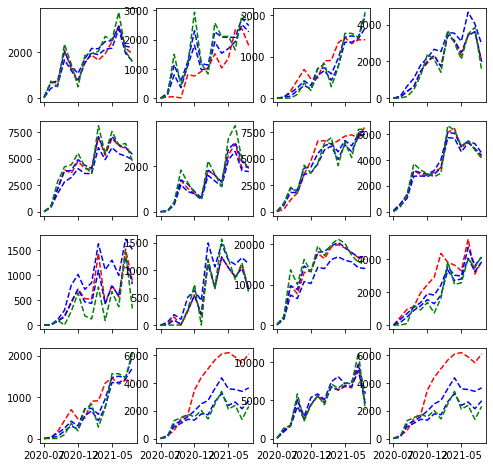

In [55]:
plotRandomRegions(correctedCvSubmissions[0], 'brand_1', True, groundTruth)

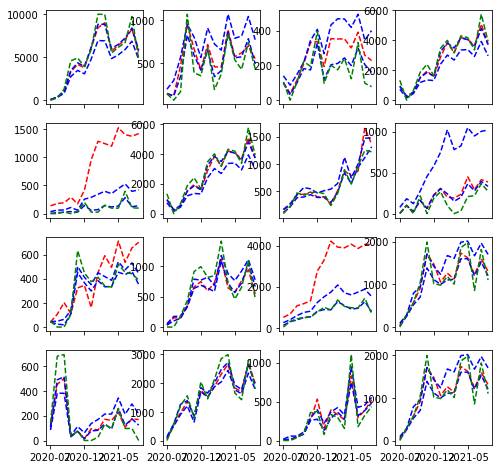

In [57]:
plotRandomRegions(correctedCvSubmissions[0], 'brand_2', True, groundTruth)

In [58]:
# predict test data
timeTest = loadTimeData(False)
timeTest['brand_1'].head(n=10)

,region,month,delta_interactions_1_f2f,delta_distinct_interactions_1_f2f,delta_interactions_1_other,delta_distinct_interactions_1_other,delta_interactions_1_phone,delta_distinct_interactions_1_phone,delta_interactions_1_video,delta_distinct_interactions_1_video,...,delta_distinct_interactions_2_video,delta_nr_contacts_1,delta_hcp_contacted_1,delta_mails_opened_1,delta_mails_clicked_1,delta_nr_contacts_2,delta_hcp_contacted_2,delta_mails_opened_2,delta_mails_clicked_2,market_potential
0,region_151,2020-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212777.53
1,region_151,2020-08,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,166766.21
2,region_151,2020-09,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,-3.0,-1.0,-3.0,-3.0,0.0,0.0,0.0,0.0,196588.63
3,region_151,2020-10,-3.0,-1.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221102.67
4,region_151,2020-11,-6.0,-4.0,0.0,0.0,-1.0,-2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188318.94
5,region_151,2020-12,0.0,0.0,0.0,0.0,-2.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226453.77
6,region_151,2021-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190923.73
7,region_151,2021-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193173.29
8,region_151,2021-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226620.01
9,region_151,2021-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235207.48


In [59]:
testMergedEstimationTimeData = mergeEstimationTimeData(submissionsTestEstimation, timeTest, False)
testMergedEstimationTimeData[0]['brand_1'].head()

,month,region,sales_estimated,delta_interactions_1_f2f,delta_distinct_interactions_1_f2f,delta_interactions_1_other,delta_distinct_interactions_1_other,delta_interactions_1_phone,delta_distinct_interactions_1_phone,delta_interactions_1_video,...,delta_distinct_interactions_2_video,delta_nr_contacts_1,delta_hcp_contacted_1,delta_mails_opened_1,delta_mails_clicked_1,delta_nr_contacts_2,delta_hcp_contacted_2,delta_mails_opened_2,delta_mails_clicked_2,market_potential
0,2020-07,region_151,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212777.53
1,2020-08,region_151,0.000000,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,166766.21
2,2020-09,region_151,0.000000,5.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,-3.0,-1.0,-3.0,-3.0,0.0,0.0,0.0,0.0,196588.63
3,2020-10,region_151,176.888308,-3.0,-1.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221102.67
4,2020-11,region_151,392.373872,-6.0,-4.0,0.0,0.0,-1.0,-2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188318.94


In [61]:
correctedTestPredictions = predictCorrectionCvModels(testMergedEstimationTimeData, correctionCvModels)
correctedTestPredictions[0]['brand_1']

,region,month,sales
0,region_151,2020-07,0.0000
1,region_151,2020-08,7.3496
2,region_151,2020-09,223.2349
3,region_151,2020-10,670.0092
4,region_151,2020-11,498.8322
...,...,...,...
695,region_200,2021-04,2183.3975
696,region_200,2021-05,2641.5144
697,region_200,2021-06,2429.7781
698,region_200,2021-07,2123.7232


In [62]:
correctedTestCiBounds = getCiBoundsForCorrectionModels(correctedTestPredictions)
correctedTestCiBounds['brand_1']

,lower,upper
0,0.00000,0.00000
1,5.69594,9.00306
2,241.36314,307.13878
3,438.81386,636.44704
4,679.87020,873.06932
...,...,...
695,2196.95102,3283.05030
696,2859.14920,3975.69536
697,2783.70754,4011.45284
698,2485.00016,4531.68920


In [63]:
correctedCvSubmissions = getSubmissionDataFromPredictionsAndCi(correctedTestPredictions, correctedTestCiBounds)

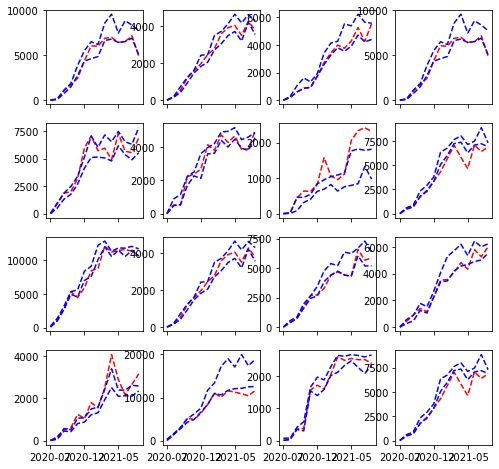

In [64]:
plotRandomRegions(correctedCvSubmissions[0], 'brand_1', False)

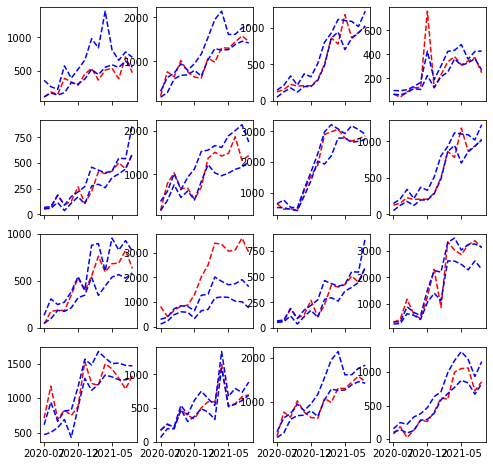

In [65]:
plotRandomRegions(correctedCvSubmissions[0], 'brand_2', False)

In [68]:
finalSubmission = getAverageSubmission(correctedCvSubmissions) 

In [71]:
finalSubmission

,region,month,brand,lower,upper,sales
0,region_151,2020-07,brand_1,0.00000,0.00000,0.00000
1,region_151,2020-08,brand_1,5.69594,9.00306,7.34952
2,region_151,2020-09,brand_1,241.36314,307.13878,279.64040
3,region_151,2020-10,brand_1,438.81386,636.44704,530.06692
4,region_151,2020-11,brand_1,679.87020,873.06932,754.68144
...,...,...,...,...,...,...
695,region_200,2021-04,brand_2,916.75156,1286.67380,1111.44168
696,region_200,2021-05,brand_2,1013.71060,1500.51572,1228.45724
697,region_200,2021-06,brand_2,850.30198,1546.66022,1251.80908
698,region_200,2021-07,brand_2,1164.43122,1650.36936,1360.01668


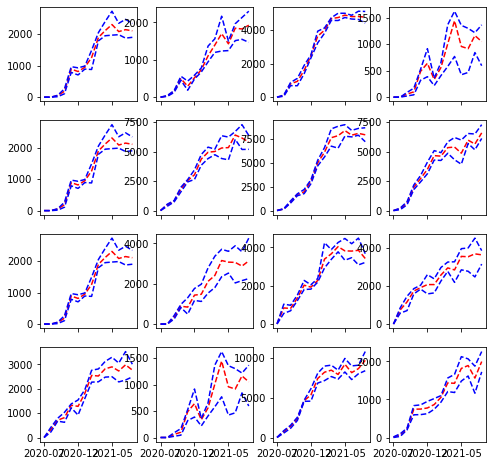

In [69]:
plotRandomRegions(finalSubmission, 'brand_1', False)

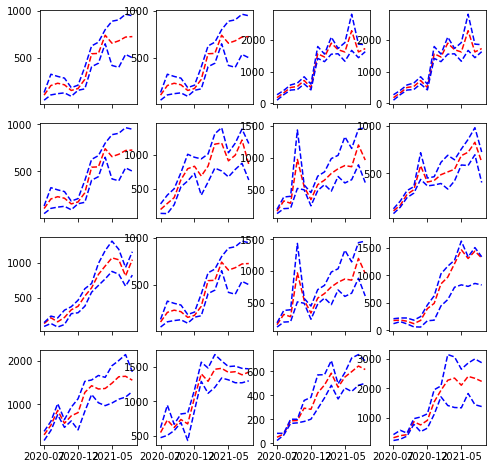

In [70]:
plotRandomRegions(finalSubmission, 'brand_2', False)